In [1]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

### 数据集读取
- Mnist数据是图像数据：(28,28,1)的灰度图

In [2]:
from sklearn.datasets import fetch_openml
from scipy.io import loadmat
mnist = loadmat('../mldata/mnist-original.mat')
mnist

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014',
 '__version__': '1.0',
 '__globals__': [],
 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
       dtype=object),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'label': array([[0., 0., 0., ..., 9., 9., 9.]])}

In [8]:
X, y = mnist["data"].T, mnist["label"].T.flatten()
X.shape

(70000, 784)

In [4]:
#返回一个折叠成一维的数组
y

array([0., 0., 0., ..., 9., 9., 9.])

![title](./img/9.png)

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
# 洗牌操作
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [26]:
shuffle_index

array([44522,  6233, 54378, ..., 47882, 31230,   457])

### 交叉验证

![title](./img/5.png)

![title](./img/7.png)

In [10]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [11]:
y_train_5[:10]

array([False, False, False, False, False, False, False, False, False,
        True])

In [13]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5,random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(max_iter=5, random_state=42)

In [14]:
sgd_clf.predict([X[35000]])

array([ True])

In [15]:
y[35000]

5.0

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.96225, 0.9645 , 0.94765])

In [17]:
X_train.shape

(60000, 784)

In [18]:
y_train_5.shape

(60000,)

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skflods = StratifiedKFold(n_splits=3,random_state=42, shuffle=True)
for train_index,test_index in skflods.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/len(y_pred))

0.9686
0.96205
0.9668


### Confusion Matrix-混淆矩阵

![title](./img/8.png)

In [20]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [21]:
y_train_pred.shape

(60000,)

In [39]:
X_train.shape

(60000, 784)

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53417,  1162],
       [ 1350,  4071]], dtype=int64)

negative class  [[ **true negatives** , **false positives** ],
 
positive class  [ **false negatives** , **true positives** ]]

* true negatives:  53,272个数据被正确的分为非5类别
* false positives：1307张被错误的分为5类别

* false negatives：1077张错误的分为非5类别
* true positives： 4344张被正确的分为5类别

一个完美的分类器应该只有**true positives** 和 **true negatives**, 即主对角线元素不为0，其余元素为0

### Precision and Recall


### **$ precision = \frac {TP} {TP + FP} $**


### **$ recall = \frac {TP} {TP + FN} $**

![title](./img/1.png)

In [23]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred)

0.7779476399770686

In [24]:
recall_score(y_train_5,y_train_pred)

0.7509684560044272

将**Precision** 和 **Recall**结合到一个称为**F1 score** 的指标,调和平均值给予低值更多权重。 因此，如果召回和精确度都很高，分类器将获得高F 1分数。

### $ F_1  = $ $2\over {1\over precision}+{1\over recall} $ $=$ $2×$ $precision×recall\over precision+recall $ $=$ $TP\over {TP}+{FN + FP\over 2}$

In [25]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7642200112633752

### 阈值对结果的影响

![title](./img/2.png)

In [26]:
y_scores = sgd_clf.decision_function([X[35000]])
y_scores

array([130851.69291613])

In [27]:
t = 50000
y_pred = (y_scores > t)
y_pred

array([ True])

Scikit-Learn不允许直接设置阈值，但它可以得到决策分数，调用其**decision_function（）**方法，而不是调用分类器的**predict（）**方法，该方法返回每个实例的分数，然后使用想要的**阈值**根据这些分数进行预测：

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [29]:
y_scores[:10]

array([ -344482.72660078, -2207948.71399372,  -747234.78009357,
        -484767.20562804,  -468335.78059607,  -408939.5646945 ,
        -605512.48296772,  -259980.56489848,  -310147.38164882,
        -387143.33685258])

In [30]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [31]:
y_train_5.shape

(60000,)

In [32]:
thresholds.shape

(60000,)

In [33]:
precisions[:10]

array([0.09035   , 0.09035151, 0.09035301, 0.09035452, 0.09035602,
       0.09035753, 0.09035904, 0.09036054, 0.09036205, 0.09036355])

In [34]:
precisions.shape

(60001,)

In [35]:
recalls.shape

(60001,)

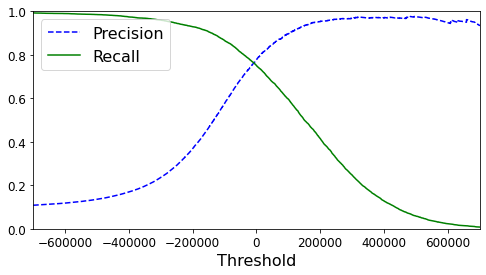

In [36]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,
             precisions[:-1],
            "b--",
            label="Precision")
    
    plt.plot(thresholds,
             recalls[:-1],
            "g-",
            label="Recall")
    plt.xlabel("Threshold",fontsize=16)
    plt.legend(loc="upper left",fontsize=16)
    plt.ylim([0,1])
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.xlim([-700000, 700000])
plt.show()

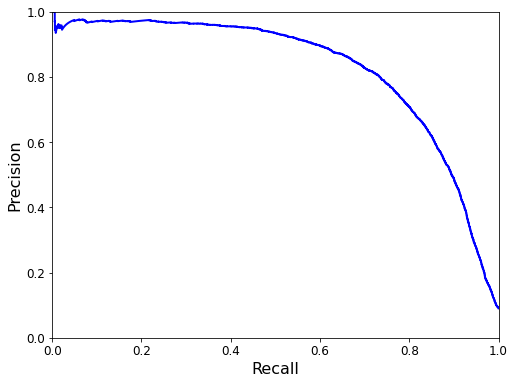

In [37]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, 
             precisions, 
             "b-", 
             linewidth=2)
    
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

### ROC curves
**receiver operating characteristic (ROC)** 曲线是二元分类中的常用评估方法
* 它与精确度/召回曲线非常相似，但ROC曲线不是绘制精确度与召回率，而是绘制**true positive rate(TPR)** 与**false positive rate(FPR)** 

* 要绘制ROC曲线，首先需要使用**roc_curve（）**函数计算各种阈值的**TPR和FPR**：

TPR = TP / (TP + FN) (Recall)

FPR = FP / (FP + TN)

In [38]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

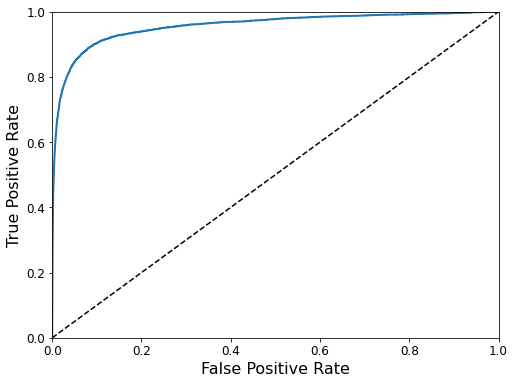

In [39]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

**虚线表示纯随机分类器的ROC曲线**; 一个好的分类器尽可能远离该线（朝左上角）。

比较分类器的一种方法是测量曲线下面积（AUC）。完美分类器的ROC AUC**等于1**，而纯随机分类器的ROC AUC**等于0.5**。 Scikit-Learn提供了计算ROC AUC的函数：

In [40]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9562435587387078